# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings

In [2]:
# import utility functions
import src.utils as utils

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')
# setup OS agnostic pathnames
# ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt

# 1.Dataset Processing

## 1.1 Data Cleaning

Load the dataset. The following tables are loaded for this project:
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [4]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

- The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

- We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [5]:
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)

The Demographic dataframe is a combination of the patient and admission datasets. Adding some columns:
- AGE: the age of the patient at the admitted year
- IS_SEPSIS: indicating whether this is a sepsis case or not


The labevents dataframe is loaded. Admissions under 18 years old are removed

In [6]:
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

Removed 8210 admissions with AGE < 18


<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

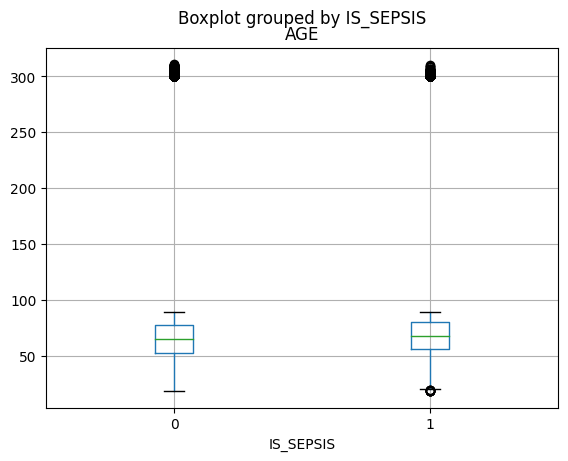

In [7]:
# plotting the age of admissions
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

In [96]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 0 admissions (0.00% over all admissions)
The median age of patients: 65


We replace those with aged > 100 by the median age of patients

In [97]:
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

The labevents dataframe is loaded. The records of admissions under 18 years old are removed.
- The empty HADM_ID is this are cleaned

In [98]:
df_labevents = dataLoader.load_labevents(df_demographic)

Calculate the TIME from for labevents from ADMITTIME to CHARTTIME
- A column NEW_ADMITTIME is added: if CHARTTIME < ADMITTIME, the NEW_ADMITTIME is the CHARTTIME, otherwise, use the ADMITTIME

In [99]:
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

## 1.2 Data Exploration

## 1.3 Feature Selection

# 2.Sepsis Risk Predicting Model Implementation

In [100]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)

In [101]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)

In [102]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

## 2.1 Survival Analysis

In [103]:
path_t4_df = ROOT_DIR / 'data' / 'Model input data'/"t4.csv"  
t4 = pd.read_csv(path_t4_df)

In [104]:
t4

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51221,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301
0,3,145834,76,0,0,8.0,7.26,329.0,11.0,7.4,...,25.6,8.2,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1
1,4,185777,47,1,0,-999.0,-999.00,-999.0,24.0,8.9,...,34.2,11.5,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7
2,6,107064,65,1,0,1.9,7.41,153.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0
3,9,150750,41,0,0,-999.0,-999.00,-999.0,30.0,-999.0,...,45.2,15.4,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5
4,11,194540,50,1,0,-999.0,-999.00,-999.0,25.0,-999.0,...,36.9,12.5,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45694,99983,117390,78,0,0,-999.0,-999.00,-999.0,28.0,9.4,...,38.9,13.6,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5
45695,99985,176670,53,0,1,-999.0,-999.00,-999.0,-999.0,-999.0,...,36.4,12.4,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0
45696,99992,197084,65,1,0,-999.0,-999.00,-999.0,22.0,7.1,...,12.9,4.7,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4
45697,99995,137810,88,1,0,1.1,7.43,382.0,-999.0,-999.0,...,-999.0,-999.0,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0


In [105]:
df_demographic[(df_demographic["SUBJECT_ID"]==417) & ( df_demographic["HADM_ID"] == 102633)]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,last_seen,total_stay,status


In [106]:
df_demographic['last_seen'] = df_demographic['DEATHTIME'].fillna(df_demographic['DISCHTIME'])
df_demographic['last_seen'] =  pd.to_datetime(df_demographic['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [107]:
df_demographic["total_stay"]  = (df_demographic["last_seen"] - df_demographic["ADMITTIME"]).dt.total_seconds() / 3600

In [108]:
df_demographic["total_stay"] = df_demographic["total_stay"].round()

In [109]:
df_demographic["status"] = df_demographic["DEATHTIME"].notna()

In [110]:
df_demographic[ df_demographic["total_stay"] < 0 ]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,last_seen,total_stay,status


In [111]:
#dropping the rows which have negative total stay i.e. discharge time less than admit time
df_demographic = df_demographic[df_demographic["total_stay"] >= 0]

In [112]:
df_demographic

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS,AGE_cat,last_seen,total_stay,status
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,F,2131-05-07,0,64,0,51-70,2196-04-10 15:54:00,27.0,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,M,2082-07-17,0,71,0,71+,2153-09-08 19:10:00,132.0,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,M,2082-07-17,0,75,0,71+,2157-10-25 14:00:00,162.0,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,M,2100-05-31,0,39,0,36-50,2139-06-09 12:48:00,69.0,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,M,2101-11-21,0,58,0,51-70,2160-11-05 14:55:00,85.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50761,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,M,2049-07-29,0,78,0,71+,2127-11-11 14:30:00,100.0,False
50762,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,1,M,2044-12-27,1,88,1,71+,2132-12-25 12:00:00,16.0,True
50763,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,1,F,2111-11-05,0,19,0,18-35,2131-04-02 15:02:00,66.0,False
50764,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,1,F,2067-09-21,1,83,0,71+,2151-03-06 09:10:00,13.0,True


In [113]:
t4

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51221,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301
0,3,145834,76,0,0,8.0,7.26,329.0,11.0,7.4,...,25.6,8.2,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1
1,4,185777,47,1,0,-999.0,-999.00,-999.0,24.0,8.9,...,34.2,11.5,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7
2,6,107064,65,1,0,1.9,7.41,153.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0
3,9,150750,41,0,0,-999.0,-999.00,-999.0,30.0,-999.0,...,45.2,15.4,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5
4,11,194540,50,1,0,-999.0,-999.00,-999.0,25.0,-999.0,...,36.9,12.5,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45694,99983,117390,78,0,0,-999.0,-999.00,-999.0,28.0,9.4,...,38.9,13.6,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5
45695,99985,176670,53,0,1,-999.0,-999.00,-999.0,-999.0,-999.0,...,36.4,12.4,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0
45696,99992,197084,65,1,0,-999.0,-999.00,-999.0,22.0,7.1,...,12.9,4.7,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4
45697,99995,137810,88,1,0,1.1,7.43,382.0,-999.0,-999.0,...,-999.0,-999.0,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0


In [114]:
df_required = pd.merge(t4, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')

In [115]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,total_stay,status
0,3,145834,76,0,0,8.0,7.26,329.0,11.0,7.4,...,1.7,8.0,81.0,253.0,15.6,15.3,2.79,19.1,259.0,False
1,4,185777,47,1,0,-999.0,-999.00,-999.0,24.0,8.9,...,1.0,6.9,89.6,207.0,12.3,13.6,3.80,9.7,186.0,False
2,6,107064,65,1,0,1.9,7.41,153.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,393.0,False
3,9,150750,41,0,0,-999.0,-999.00,-999.0,30.0,-999.0,...,1.1,41.6,50.1,258.0,12.7,13.4,5.46,7.5,117.0,True
4,11,194540,50,1,0,-999.0,-999.00,-999.0,25.0,-999.0,...,1.1,7.6,91.4,229.0,13.0,13.4,4.31,8.5,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45694,99983,117390,78,0,0,-999.0,-999.00,-999.0,28.0,9.4,...,1.1,-999.0,-999.0,253.0,13.4,12.7,4.21,7.5,74.0,False
45695,99985,176670,53,0,1,-999.0,-999.00,-999.0,-999.0,-999.0,...,-999.0,8.1,85.1,349.0,-999.0,14.0,4.20,13.0,398.0,False
45696,99992,197084,65,1,0,-999.0,-999.00,-999.0,22.0,7.1,...,1.1,9.1,84.9,188.0,12.9,16.3,1.35,21.4,72.0,False
45697,99995,137810,88,1,0,1.1,7.43,382.0,-999.0,-999.0,...,1.9,-999.0,-999.0,-999.0,19.7,-999.0,-999.00,-999.0,77.0,False


In [116]:

df_required[20063:20064]

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,total_stay,status
20063,23473,136025,67,0,0,1.1,-999.0,-999.0,22.0,8.1,...,1.3,1.7,95.3,344.0,14.3,14.6,4.74,29.6,195.0,False


In [117]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)

In [118]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [177]:
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [178]:
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)

test_sepsis = data_x_test["IS_SEPSIS"]
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [179]:
df_test = pd.concat([data_x_test, data_y_test], axis=1)
df_test[df_test["total_stay"] < 100]

,AGE,GENDER_NUM,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,ITEMID_50902,ITEMID_50912,ITEMID_50931,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,status,total_stay
17931,61,1,-999.0,7.29,-999.0,24.0,-999.0,106.0,0.8,116.0,...,1.3,-999.0,-999.0,246.0,13.4,12.6,4.23,13.7,False,41.0
10088,68,0,-999.0,-999.00,-999.0,27.0,-999.0,106.0,1.2,99.0,...,1.3,-999.0,-999.0,272.0,14.5,15.1,4.96,5.7,False,80.0
17665,64,0,1.8,-999.00,-999.0,29.0,9.0,101.0,0.8,114.0,...,1.1,24.3,67.9,333.0,12.6,15.4,4.52,14.0,False,71.0
891,74,0,-999.0,-999.00,-999.0,28.0,-999.0,103.0,1.2,90.0,...,1.1,-999.0,-999.0,141.0,13.2,-999.0,-999.00,7.8,False,93.0
25823,63,1,2.2,7.31,54.0,20.0,7.6,107.0,0.8,161.0,...,1.0,11.3,85.8,289.0,12.3,13.2,5.06,13.1,False,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28376,59,1,-999.0,-999.00,-999.0,22.0,9.4,106.0,0.7,189.0,...,-999.0,13.3,82.5,281.0,-999.0,18.7,5.13,12.3,False,95.0
26876,39,0,-999.0,7.36,609.0,23.0,8.7,105.0,1.1,116.0,...,-999.0,25.8,61.7,190.0,-999.0,13.4,4.08,9.0,False,38.0
32751,32,0,2.5,7.42,91.0,23.0,-999.0,104.0,1.3,97.0,...,1.2,23.8,68.7,240.0,13.8,12.9,4.49,7.0,False,64.0
32263,27,0,3.9,7.40,301.0,-999.0,-999.0,-999.0,1.0,-999.0,...,1.1,-999.0,-999.0,382.0,13.2,13.6,4.73,12.7,True,5.0


In [180]:
#data_y = df_required[["status","total_stay"]].to_numpy()
#data_y = df_required[["status","total_stay"]].to_records(index=False)
#np.array(data_y)
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([( True, 208.), (False, 180.), (False, 144.), ...,
           (False, 128.), (False, 188.), (False, 255.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [181]:
#data_x = df_required.drop(["status","total_stay","SUBJECT_ID","HADM_ID","IS_SEPSIS"], axis = 1)

In [182]:
data_x_train

,AGE,GENDER_NUM,ITEMID_50813,ITEMID_50820,ITEMID_50821,ITEMID_50882,ITEMID_50893,ITEMID_50902,ITEMID_50912,ITEMID_50931,...,ITEMID_51221,ITEMID_51222,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301
39799,80,0,1.3,-999.00,-999.0,29.0,-999.0,100.0,2.2,264.0,...,21.0,7.1,1.0,32.1,48.5,235.0,11.0,13.9,2.06,5.5
963,58,0,-999.0,-999.00,-999.0,24.0,-999.0,106.0,1.0,128.0,...,36.6,13.5,1.1,-999.0,-999.0,212.0,12.6,12.5,4.31,8.6
32590,64,0,-999.0,-999.00,-999.0,27.0,8.3,108.0,0.8,98.0,...,27.3,9.0,1.5,16.5,77.5,191.0,16.3,16.5,3.50,7.8
2659,31,0,6.0,7.49,204.0,-999.0,-999.0,-999.0,1.1,-999.0,...,39.5,13.6,1.0,-999.0,-999.0,186.0,12.3,13.6,4.39,7.1
33730,78,1,0.9,-999.00,-999.0,24.0,-999.0,97.0,0.7,188.0,...,36.2,11.7,1.1,6.9,83.8,300.0,11.8,12.9,3.84,12.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45629,51,0,1.9,-999.00,-999.0,30.0,8.4,104.0,0.8,123.0,...,34.2,11.8,1.5,13.3,78.4,50.0,16.9,19.9,3.35,4.5
18465,67,0,2.1,7.46,236.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0
14753,75,0,-999.0,7.40,205.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,32.9,11.4,-999.0,-999.0,-999.0,118.0,-999.0,13.4,3.47,7.9
37411,35,0,-999.0,-999.00,-999.0,28.0,10.1,100.0,0.8,124.0,...,45.7,16.3,1.3,9.4,88.8,288.0,14.7,12.8,5.11,7.4


In [183]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

In [184]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


CoxPHSurvivalAnalysis()

In [185]:
pd.Series(estimator.coef_, index=data_x_train.columns)

AGE             0.025012
GENDER_NUM      0.107973
ITEMID_50813    0.000265
ITEMID_50820    0.000033
ITEMID_50821    0.000360
ITEMID_50882   -0.000692
ITEMID_50893   -0.000047
ITEMID_50902    0.000134
ITEMID_50912   -0.000739
ITEMID_50931    0.000101
ITEMID_50970    0.000256
ITEMID_51006    0.001773
ITEMID_51221   -0.000776
ITEMID_51222    0.000164
ITEMID_51237   -0.000772
ITEMID_51244   -0.002291
ITEMID_51256    0.002401
ITEMID_51265   -0.001032
ITEMID_51274    0.000831
ITEMID_51277    0.000192
ITEMID_51279   -0.000529
ITEMID_51301    0.002296
dtype: float64

In [186]:
#pred_surv = estimator.predict_survival_function(data_x_test[:25])
pred_surv = estimator.predict_survival_function(data_x_test[:100])


c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [187]:
data_y_test

rec.array([(False,  41.), (False,  80.), (False,  71.), ...,
           (False, 104.), (False, 226.), (False, 172.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [188]:
data_y_test[49:50]

rec.array([(False, 260.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [189]:
pred_surv

array([StepFunction(x=array([-0.000e+00,  1.000e+00,  2.000e+00, ...,  4.866e+03,  4.954e+03,
               7.072e+03]), y=array([0.99994144, 0.99957058, 0.999141  , ..., 0.21994804, 0.15525797,
              0.15525797]), a=1.0, b=0.0)                                                            ,
       StepFunction(x=array([-0.000e+00,  1.000e+00,  2.000e+00, ...,  4.866e+03,  4.954e+03,
               7.072e+03]), y=array([0.99995507, 0.99967053, 0.9993409 , ..., 0.31291133, 0.23953464,
              0.23953464]), a=1.0, b=0.0)                                                            ,
       StepFunction(x=array([-0.000e+00,  1.000e+00,  2.000e+00, ...,  4.866e+03,  4.954e+03,
               7.072e+03]), y=array([0.99992229, 0.99943022, 0.99886029, ..., 0.13405506, 0.08444202,
              0.08444202]), a=1.0, b=0.0)                                                            ,
       StepFunction(x=array([-0.000e+00,  1.000e+00,  2.000e+00, ...,  4.866e+03,  4.954e+03,
         

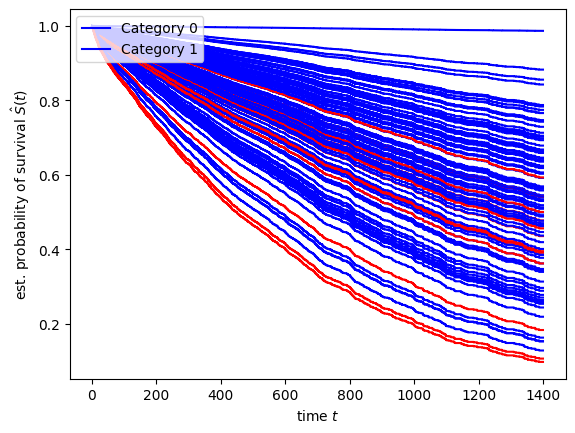

In [190]:
category_colors = {0 : 'blue', 1 : 'red'}
categories = test_sepsis

time_points = np.arange(1, 1400)
#for i, surv_func in enumerate(pred_surv):
for i, (surv_func, category) in enumerate(zip(pred_surv, categories)):

    plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}", color=category_colors.get(category, 'black'))
    x=3
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="upper left")


#legend_labels = {category: f"Category {category}" for category in category_colors.keys()}
legend_labels = {category: f"Category {category}" for category in category_colors.keys()}
handles, _ = plt.gca().get_legend_handles_labels()

plt.legend(handles, [legend_labels[label] for label in category_colors.keys()], loc="upper left")

plt.show()

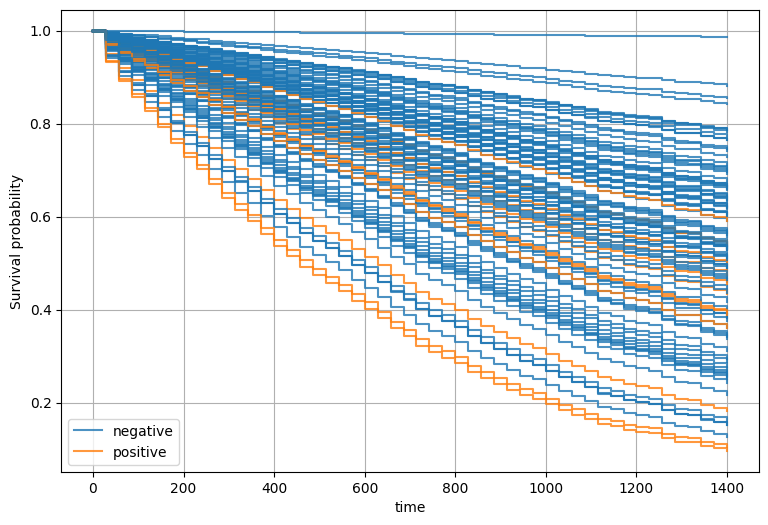

In [191]:
#surv_fns = coxnet_pred.predict_survival_function(data_x_test[:100])

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [192]:
legend_labels

['negative', 'positive']

In [193]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_train)
result = concordance_index_censored(data_y_train["status"], data_y_train["total_stay"], prediction)
result[0]

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.6938049978555895

In [194]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)

ITEMID_50813    0.628738
ITEMID_51006    0.616771
ITEMID_51274    0.608877
ITEMID_51237    0.608442
ITEMID_51301    0.607476
ITEMID_50912    0.596306
AGE             0.595692
ITEMID_51277    0.589158
ITEMID_50821    0.574001
ITEMID_50970    0.568922
ITEMID_50931    0.568908
ITEMID_50820    0.557895
ITEMID_51256    0.553170
ITEMID_50893    0.526903
ITEMID_50902    0.526133
GENDER_NUM      0.522984
ITEMID_51221    0.521657
ITEMID_51222    0.504613
ITEMID_51279    0.501467
ITEMID_51244    0.491235
ITEMID_51265    0.486389
ITEMID_50882    0.438198
dtype: float64

In [195]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder

pipe = Pipeline(
    [
        ("encode", OneHotEncoder()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

In [196]:
"""
from sklearn.model_selection import GridSearchCV, KFold

#param_grid = {"select__k": np.arange(1, data_x_train.shape[1] + 1)}
param_grid = {"select__k": np.arange(15, 19 + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x_train, data_y_train)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

"""

'\nfrom sklearn.model_selection import GridSearchCV, KFold\n\n#param_grid = {"select__k": np.arange(1, data_x_train.shape[1] + 1)}\nparam_grid = {"select__k": np.arange(15, 19 + 1)}\ncv = KFold(n_splits=3, random_state=1, shuffle=True)\ngcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)\ngcv.fit(data_x_train, data_y_train)\n\nresults = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)\nresults.loc[:, ~results.columns.str.endswith("_time")]\n\n'

In [197]:
Xt = data_x_train.copy()
y = data_y_train.copy()

In [198]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [199]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-

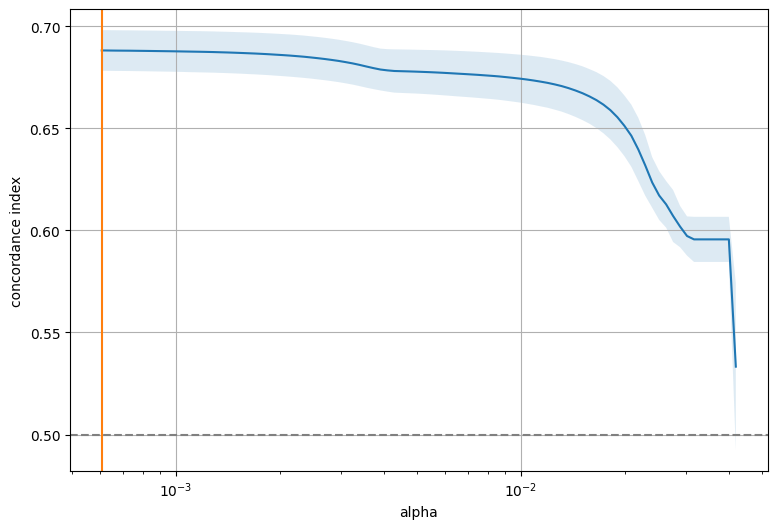

In [200]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 13


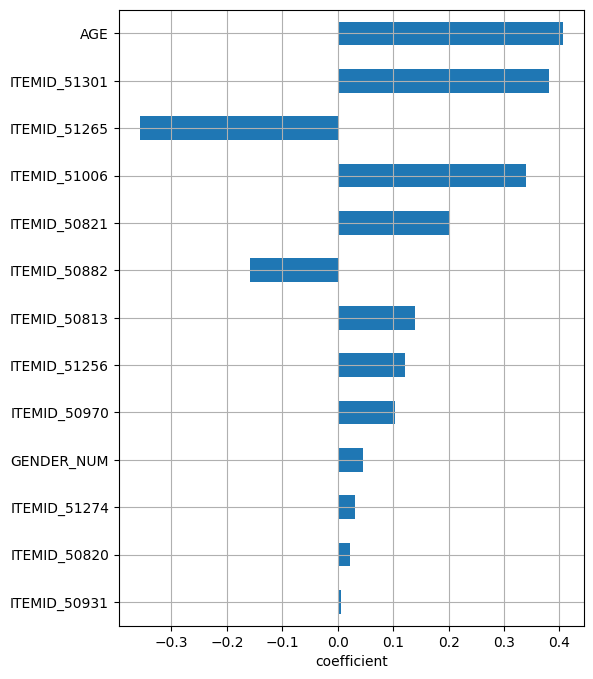

In [201]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [202]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.0006086252943981643],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\apata\Desktop\Royal Perth project\data-science-capstone-project\.venv\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


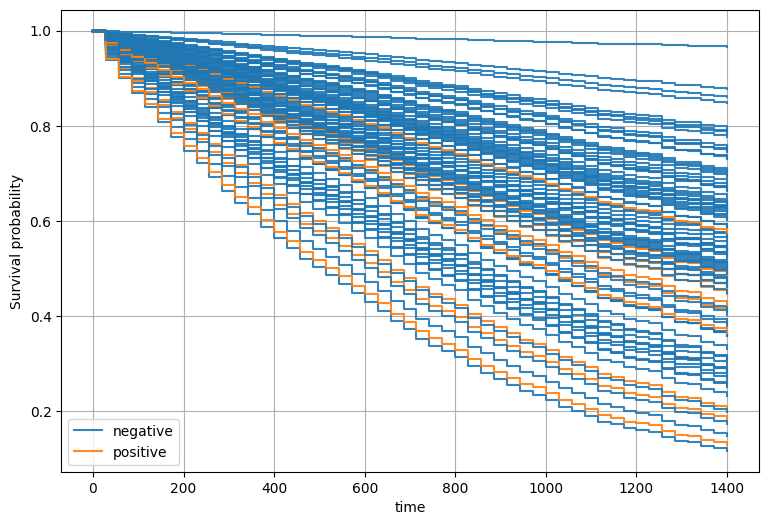

In [207]:
surv_fns = coxnet_pred.predict_survival_function(data_x_test[:100])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, test_sepsis):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)



In [204]:
print(legend_handles,legend_labels)

[<matplotlib.lines.Line2D object at 0x00000297D90AA250>, <matplotlib.lines.Line2D object at 0x00000297D9375C90>] ['negative', 'positive']


In [205]:
y

rec.array([( True, 208.), (False, 180.), (False, 144.), ...,
           (False, 128.), (False, 188.), (False, 255.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

## 2.5 LSTM + Attention Model

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation